<a href="https://colab.research.google.com/github/Dmitri9149/PyTorch-Transformer-from-scratch/blob/main/Basic_v3_Exp_PyTorch_Transformer_scratch_29_01_2021_13_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -U: Upgrade all packages to the newest available version
!pip install -U d2l
!pip install requests
import requests 
from IPython import display
from IPython.display import set_matplotlib_formats
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd
import os
import time
import hashlib
import zipfile
import collections
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
import numpy as np
from typing import Tuple, NewType, Union, Any, TypeVar
from typing import Dict, List, Counter
from matplotlib import pyplot as plt

Requirement already up-to-date: d2l in /usr/local/lib/python3.6/dist-packages (0.16.1)


- positional function coding_positionsA with delta = 10 shift 6 is used; FACTOR_B = 0.0 
- the dim of every of 4 heads is decreased from 64 to 16 (before concatenation).   
-600 pairs, 200 epochs

Some comments to the notebook: 
- multihead attention -> separate independently formed heads
- no linear transformation for 'keys' in HeadAttention  
- MultiHeadAttention module was changed
- PositionalEncoder is changed 
- the notebook is for experiments, test code and comments are not 
eliminated 
- my comments are with 3 # -> ### mycomments
- code from d2l.ai project : https://github.com/d2l-ai/d2l-en and http://d2l.ai/index.htmlis is marked as   ### from d2l.ai
- function for positional encoding : .... depend on notebook, see the code 

Some functions to calculate the 'attention'

In [2]:
### prediction of padding tokens should be excluded from loss calculations;
### this function mask irrelevant entries with zero values so later 
### multiplication of any irrelevant prediction with zero equals to zero.

### modified code from d2l.ai
def sequence_mask(X:Tensor, valid_len: Tensor, value: int = 0)-> Tensor:
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [3]:
### modified code from d2l.ai


### X: 3D Tensor of scores where some scores 'are not to be used', for
### example because corresponds to <pad> sequences
### or correspond to 'future' tokens in target sequenses (tokens in lang to which we translate)
### which can not be used for the prediction from the 'past' tokens to the moment 
### X-> 3D Tensor : (batch_size, number of queries we use, number of key/value pairs)
### if masking is independent of a query we use to generate the sores -> valid_lens is 1D
### it happens in case of padding
### if masking depens on the query we use : valid _lens is 2D
### it happens in Decoder Blocks, where all queries have different 'past' and 'future'
def masked_softmax(X: Tensor,  valid_lens: Tensor) -> Tensor:
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return F.softmax(X.reshape(shape), dim=-1)

In [4]:
### modified code from 2dl.ai
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, valid_lens: Tensor=None) -> Tensor:
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [5]:
### to visualize the'attention'
### from d2l.ai
def show_heatmaps(matrices,
                  xlabel,
                  ylabel,
                  titles=None,
                  figsize=(3.5, 3.5),
                  cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows,
                                 num_cols,
                                 figsize=figsize,
                                 sharex=True,
                                 sharey=True,
                                 squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

Transformer modules

In [6]:
### one head module
class AttentionHead(nn.Module):
    def __init__(self, key_size: int, query_size: int, value_size: int,
                 dropout: float, bias: float): 
        super().__init__()
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, key_size, bias=bias)
        self.W_v = nn.Linear(value_size,16, bias=bias)

    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, 
                valid_lens: Tensor) -> Tensor:
        queries = self.W_q(queries)
        keys = keys
        values = self.W_v(values)

        return self.attention(queries, keys, values, valid_lens)

In [7]:
### num_hiddens : the size of the vector which represent token after the 
### output from the forward function of the module;
### or in another way: size of tokens after the MultiHeadAttention module
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size: int, query_size: int, value_size: int, 
                num_hiddens: int, num_heads: int, dropout: float, 
                bias: float=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(key_size, query_size, value_size, dropout, bias) for _ in range(num_heads)]
        )
        self.W_o = nn.Linear(16*self.num_heads, num_hiddens,bias=bias)

    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, 
                valid_lens: Tensor) -> Tensor:


        return self.W_o(
            torch.cat([h(queries, keys, values, valid_lens) for h in self.heads], dim=-1)
        )

In [8]:
### here the position wector is random vector of 0 and 1 (normilized)
POS = ((torch.FloatTensor(10,8).uniform_() > 0.6)).float()
SUM_POS = torch.sum(POS, dim =1).reshape(-1,1)
SUM_POS

tensor([[3.],
        [4.],
        [6.],
        [1.],
        [6.],
        [2.],
        [4.],
        [2.],
        [5.],
        [2.]])

In [9]:
POS

tensor([[0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0., 1., 0., 0.]])

In [10]:
NORMALIZED_POS = POS / SUM_POS
NORMALIZED_POS

tensor([[0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500],
        [0.0000, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
        [0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000]])

In [11]:
###################### end of test

Position encoding functions

In [12]:
def indicator(x):
  if (x == 0):
    z = 0
  else: 
    z = 1
  return z

In [13]:
### we have sequence of tokens with length num_steps
### we have siz eof every token : num_hiddens
### have to make positional encoding functional with output num_hiddens 
### to code positions in our sequence
def coding_positionsA(factor, num_steps, num_hiddens, delta, shift):
  full_steps = num_hiddens //delta
  remainder = num_hiddens % delta ### num_hiddens =  full * num_steps + reminder
  pos = torch.zeros(num_steps,num_hiddens).float()
  max_steps= full_steps + indicator(remainder)
  for i in range(num_steps):
    for j in range(i*shift, min(num_hiddens, i*shift +delta)):
      pos[i,j]=torch.tensor(1.)

  sums = torch.sum(pos, dim =1).reshape(-1,1)

  pos = (pos / sums)* torch.tensor(factor)


  return pos

In [14]:
coding_positionsA(1.,10,64,10,6)



tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0

In [15]:
### STOP

In [16]:

### encode positions in the sequence 0,..., max - 1 
### max correspond to max num tokens in the sentences 
### here max = 10 , for 0 -> 1 and for 9 -> -1

def positions(n: int, max : int = 10) -> float:
  x = ((5. - n * (max)/(max -1)) / max) * 2.
  return x

In [17]:
print(positions(0), positions(9))

1.0 -1.0


In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens: int,
                       dropout: float,
                       max_len: int=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        ### create long enought 'positions' (first axis) with 0 s and 1 s in second axis
        ### digital parameter ->'propability' of 0 value in the sequence with length = num_hiddens
###        FACTOR_A = 0.
###        self.positions = ((torch.FloatTensor(max_len,num_hiddens).uniform_() > FACTOR_A)/num_hiddens).double()
###        sums = torch.sum(self.positions, dim =1).reshape(-1,1)
####        self.positions = (self.positions / sums) * FACTOR_B
###        self.positions = torch.zeros(max_len, num_hiddens)
###        for i in range(num_hiddens):
###          self.positions[:,i] = positions(i)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
###        self.P[:,:,:] =  self.positions
###==============================================================================
        FACTOR_B = 0.0
        delta, shift,  num_steps = (10 , 6 , 10)
###=============================================================================
        for i in range(num_steps):
          for j in range(num_hiddens):
            self.P[:, i, j]= coding_positionsA(FACTOR_B,num_steps, num_hiddens, delta, shift)[i,j]


    def forward(self, X: Tensor)-> Tensor:
###        X = X
        X = X + self.P[:, :X.shape[1], :].to(X.device)
###        print(torch.sum(X, dim = 2)[0,0])
        return self.dropout(X)

In [19]:
### from d2l.ai
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [20]:
### from d2l.ai
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [21]:
### from d2l.ai
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [22]:
### from d2l.ai
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [23]:
### from d2l.ai
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [24]:
### from d2l.ai
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [25]:
### from d2l.ai
class TransformerEncoder(Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
###        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
###            self.attention_weights[
###                i] = blk.attention.attention.attention_weights
        return X

In [26]:
### from d2l.ai
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [27]:
### from d2l.ai
class AttentionDecoder(Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [28]:
### modified code from d2l.ai
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
 ###       self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
###            self._attention_weights[0][
###                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
###            self._attention_weights[1][
###                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
       return 0

Data Downloading and Reading from web and then from .

The used data are bilingual sentence pairs from Tatoeba project : 
http://www.manythings.org/anki/

In [29]:
### Each line in the dataset is a tab-delimited pair of an English text 
### sequence and the translated French text sequence.
### Each text sequence can be just one sentence or a paragraph of multiple sentences.


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [30]:
### from d2l.a
def read_data_nmt() -> str:
    """Load the English-French dataset."""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

In [31]:
### from d2l.ai
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [32]:
### from d2l.ai
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)

    return os.path.join(base_dir, folder) if folder else data_dir

In [33]:
### data pairs for the translation looks like this: 
raw_text = read_data_nmt()  ### raw_text: string
print(raw_text[:500])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
Go on.	Poursuis.
Go on.	Continuez.
Go on.	Poursuivez.
Hello!	Bonjour !
Hello!	Salut !
I see.	Je comprends.
I try.	J'essaye.
I won!	J'ai gagné !
I won!	Je l'ai emporté !
I won.	J’ai gagné.
Oh no!	Oh non !
Attack!	Attaque !
Attack!	Attaquez !
Cheers!	Santé !
Cheers!	À votre santé !
Cheers!	Merci !



Vocabulary 

In [34]:
### modified code form d2i.ai
### Union type; Union[X, Y] means either X or Y.
### tokens : list of strings OR list of list of strings
def count_corpus(tokens: Union[List[str],List[List[str]]])-> Dict[str,int]:
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [35]:
############################ test

In [36]:
count_corpus(['asd', 'sss', 'iouyio', 'huhu', 'huhu'])

Counter({'asd': 1, 'huhu': 2, 'iouyio': 1, 'sss': 1})

In [37]:
count_corpus([['aaa', 'bbb'], ['ccc', 'ddd','aaa']])

Counter({'aaa': 2, 'bbb': 1, 'ccc': 1, 'ddd': 1})

In [38]:
####################################### end of test

In [39]:
### modified code from d2l.ai
### Union type; Union[X, Y] means either X or Y.
### tokens : 1D list of strings or 2D list of list of strings 
class Vocab:
    """Vocabulary for text."""
    def __init__(self, 
                 tokens: Union[List[List[str]],List[str]] =None, 
                 min_freq: int =0, 
                 reserved_tokens: List[str]=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        ### the list below is sorted basing on freqs of tokens
###        self.token_freqs: List[Tuple(str,int)] = sorted(counter.items(),
        self.token_freqs = sorted(counter.items(),
                          key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk: int = 0

        uniq_tokens: List[str] = ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]

        self.idx_to_token: List[str] = [] 
        self.token_to_idx: Dict[str,int] = dict()
###        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self) -> int:
        return len(self.idx_to_token)

    def __getitem__(self, 
                    tokens: Union[Any, List[str], Tuple[str]]
                    ) -> Union[str, List[str]]:
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, 
                  indices: Union[int, List[int], Tuple[int]]
                  )-> Union[int, List[int]]:
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [40]:
################################# test

In [41]:
tokens_a = [['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him'],
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and'],
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']]

In [42]:
vocab_a = Vocab(tokens_a)

In [43]:
print(vocab_a.token_to_idx.items())

dict_items([('<unk>', 0), ('and', 1), ('the', 2), ('to', 3), ('was', 4), ('his', 5), ('time', 6), ('traveller', 7), ('for', 8), ('so', 9), ('it', 10), ('will', 11), ('be', 12), ('convenient', 13), ('speak', 14), ('of', 15), ('him', 16), ('expounding', 17), ('a', 18), ('recondite', 19), ('matter', 20), ('us', 21), ('grey', 22), ('eyes', 23), ('shone', 24), ('twinkled', 25), ('usually', 26), ('pale', 27), ('face', 28), ('flushed', 29), ('animated', 30)])


In [44]:
print(vocab_a.token_freqs)

[('and', 3), ('the', 2), ('to', 2), ('was', 2), ('his', 2), ('time', 1), ('traveller', 1), ('for', 1), ('so', 1), ('it', 1), ('will', 1), ('be', 1), ('convenient', 1), ('speak', 1), ('of', 1), ('him', 1), ('expounding', 1), ('a', 1), ('recondite', 1), ('matter', 1), ('us', 1), ('grey', 1), ('eyes', 1), ('shone', 1), ('twinkled', 1), ('usually', 1), ('pale', 1), ('face', 1), ('flushed', 1), ('animated', 1)]


In [45]:
for i in [0, 2]:
    print('words:', tokens_a[i])
### supply list of 'keys' where 'keys' are tokens: strings
    print('indices:', vocab_a[tokens_a[i]])

words: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
indices: [2, 6, 7, 8, 9, 10, 11, 12, 13, 3, 14, 15, 16]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [25, 1, 5, 26, 27, 28, 4, 29, 1, 30, 2]


In [46]:
vocab_a['time']

6

In [47]:
vocab_a['jjjj']

0

In [48]:
vocab_a.to_tokens(2)

'the'

In [49]:
vocab_a.to_tokens([1,2,3])

['and', 'the', 'to']

In [50]:
### vocab_a.to_tokens(2.6)   -> error

In [51]:
vocab_a.__getitem__(('and','ffff','the'))

[1, 0, 2]

In [52]:
vocab_a.__getitem__(['and','ffff','the'])

[1, 0, 2]

In [53]:
vocab_a.__getitem__('and')

1

In [54]:
vocab_a.__getitem__(vocab_a)  ### not an error !!!

0

In [55]:
vocab_a.__getitem__(count_corpus)   ### not an error !! 

0

In [56]:
### vocab_a.__getitem__(count_corpus)   ### not an error !! 

In [57]:
### vocab_a.__getitem__(dddd)   ###error !!  because the 'dddd' name is not defined

In [58]:
################################## end of test


Text preprocessing , tokenization.

Preprocess the text which was read from a file. Tokenize it. 

In [59]:
#### preprocessing of the raw text as a 'one big string'
### modified code from from d2l.ai
def preprocess_nmt(text: str) -> str:
    """Preprocess the English-French dataset."""
### Python has no type 'char' here 'str' correspond to str of length 1
### here 'char: str' has type we will get after enumerate(text) 
    def no_space(char: str, prev_char: str) -> bool:
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

In [60]:
### tokenize the preprocessed text 

### modified code form d2l.ai
def tokenize_nmt(text:str, num_examples: int=None) -> Tuple[List[List[str]], List[List[str]]]:
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

Dataset for translation.
Functions for processing of arrays of tokens/indices 
Truncate/pad , adding "\<eos>" token etc...


In [61]:
### trancate and pad the list of tokens (where token is a string)
### modified code from d2l.ai
def truncate_pad(line:List[int], num_steps:int, padding_token: str) -> List[int]:
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

In [62]:
### modified code from d2l.ai
### ppend the  “<eos>” (end of sequence) token to the end of every sequence 
### to indicate the end of the sequence.
### when a model is predicting by generating a sequence token after token, 
### the generation of the “<eos>” token can indicates that the output sequence is complete.
### in 'valid_len' we record the length of each text sequence excluding the padding tokens.
### after the <eos> addition we make trancate_pad(lines)
def build_array_nmt(lines: List[List[str]], vocab, num_steps: int) -> Tuple[Tensor,Tensor]:
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

load_data_nmt :  
load_data_nmt function return the data iterator, together with the vocabs for both the source language and the target language : 
- 1.preprocess the text as one string
- 2.tokenize
- 3.make Vocab
- 4.truncate/pad/<eos> 
- 5.build iterator

In [63]:
### modified code from d2l.ai
T_co = TypeVar('T_co', covariant=True)
def load_array(data_arrays: List[Tensor],
               batch_size: int,
               is_train: bool=True) -> DataLoader[T_co]:
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [64]:
### modified code from d2l.ai
def load_data_nmt(batch_size: int,
                  num_steps: int,
                  num_examples: int=600) -> DataLoader[T_co]:
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [65]:
### the blue scores, to estimate the quality of translation
### from d2l.ai
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [66]:
### from d2l.ai
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [67]:
### from d2l.ai
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [68]:
### regulate the value of gradient, too big gradient is not allowed 
### from d2l.ai
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [69]:
### accumulate date in training process
### from d2l.ai
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [70]:
### from d2l.ai
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [71]:
### from d2l.ai
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [72]:
### from d2l.ai
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [73]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [74]:
### to plot data
### from d2l.ai
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [75]:
### work with time 
### from d2l.ai
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [76]:
### training function
### modified from d2l.ai
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
 

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric =Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input =torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

In [77]:
### new PositionalEncoding !!! (see code for exact function)
### new MultiHeadAttention !!!

In [78]:
### from d2l.ai
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

loss 0.032, 2505.5 tokens/sec on cpu


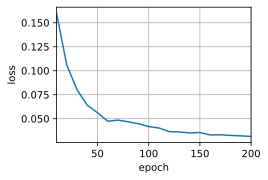

In [79]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 64, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 64, 64, 4
key_size, query_size, value_size = 64, 64, 64
norm_shape = [64]


#### THE LAST PARAMETER IM load_data_nmt FUNCTION IS NUMBER OF SENTENCES FOR 
### TRAINING  
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps,600)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [80]:
### prediction
### from d2l.ai
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [81]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .', 'got it !', 'hug me .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .', 
'j\'ai pigé !', 'Serre-moi dans tes bras !']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
got it ! => compris !,  bleu 0.000
hug me . => <unk> dans tes bras !,  bleu 0.832


In [82]:
### from heylingo
engs_heylingo = ['it is how it is .','i paid .','i can .', 'i\'m going out .',
'it is a book .', 'i need to know .', 'the man who saw us .', 'she works in an office .', 'a price war .',
'he is seen as a safe pair of hands .','the fighting continued all night .', 'it turned out all right in the end .']
fras_heylingo = ['c\'estcommeça .', 'j\’ai payé .', 'je peux .', 'je sors .',
'c\'est un livre .', 'je dois savoir .', 'l\’homme qui nous a vus .', 'elle travaille dans un bureau .', 'une guerre des prix .',
'on le considère comme quelqu\’un de sûr .','les combats se sont poursuivis toute la nuit .','finalement tout s\’est bien passé .']



In [83]:
for eng, fra in zip(engs_heylingo, fras_heylingo):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

it is how it is . => <unk> tomber .,  bleu 0.000
i paid . => j’ai payé .,  bleu 0.687
i can . => je sais <unk> .,  bleu 0.000
i'm going out . => je suis <unk> .,  bleu 0.000
it is a book . => il est <unk> .,  bleu 0.000
i need to know . => je <unk> .,  bleu 0.000
the man who saw us . => <unk> tomber .,  bleu 0.000
she works in an office . => elle <unk> .,  bleu 0.000
a price war . => <unk> .,  bleu 0.000
he is seen as a safe pair of hands . => il est <unk> .,  bleu 0.000
the fighting continued all night . => <unk> !,  bleu 0.000
it turned out all right in the end . => <unk> .,  bleu 0.000
